In [40]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import os
import calpgs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [41]:
# read results of LDL other
# (1) perform regression with interaction term of pred x PC1
# (2) perform regresion with multiple interaction term

In [42]:
DATA_DIR = "../compile-data/out/per-trait-info/"

In [123]:
COVAR_COLS = [
    "AGE",
    "SEX",
    "DEPRIVATION_INDEX",
    "log_BMI",
    "income",
    "ever_smoked",
    "drink_alcohol",
    "glasses",
    "years_of_edu",
] + [f"PC{i}" for i in range(1, 11)]
FIT_COLS = ["PGS"] + COVAR_COLS

In [124]:
trait, indiv_group = "LDL", "other"
trait, indiv_group = "height", "other"
trait, indiv_group = "log_BMI", "white"
# trait, indiv_group = "LDL", "white"

In [125]:
# read data
# prefix = f"out/OLD-pgs-interact/model-fit/joint+interact/{trait}-{indiv_group}"
prefix = f"out/model-fit/joint/{trait}-{indiv_group}"

df_predint = pd.read_csv(f"{prefix}.predint.tsv", sep="\t", index_col=0)
df_params = pd.read_csv(f"{prefix}.params.tsv", sep="\t", index_col=0)
df_raw = pd.read_csv(
    f"../compile-data/out/per-trait-info/{trait}.tsv.gz", sep="\t", index_col=0
)

In [126]:
prefix = f"out/model-fit/joint+slope/{trait}-{indiv_group}"

df_predint = pd.read_csv(f"{prefix}.predint.tsv", sep="\t", index_col=0)

In [127]:
df_tmp = df_predint[df_predint.SEX > 0]
reg = stats.linregress(x=df_tmp["cal_pred"], y=df_tmp["pheno"])
print(f"SEX > 0: pheno = {reg.slope:.2g} * pred + {reg.intercept:.3g}")
df_tmp = df_predint[df_predint.SEX < 0]
reg = stats.linregress(x=df_tmp["cal_pred"], y=df_tmp["pheno"])
print(f"SEX < 0: pheno = {reg.slope:.2g} * pred + {reg.intercept:.3g}")

reg = stats.linregress(x=df_predint["cal_pred"], y=df_predint["pheno"])
print(f"Overall: pheno = {reg.slope:.2g} * pred + {reg.intercept:.3g}")

SEX > 0: pheno = 0.97 * pred + 0.113
SEX < 0: pheno = 1.1 * pred + -0.341
Overall: pheno = 1 * pred + -0.119


In [128]:
for df in [df_predint[df_predint.SEX > 0], df_predint[df_predint.SEX < 0], df_predint]:
    reg = sm.WLS(
        endog=df["pheno"],
        exog=sm.add_constant(df["cal_pred"]),
        weights=1 / (df["cal_predstd"] ** 2),
    ).fit()
    print(f"pheno = {reg.params['cal_pred']:.2g} * pred + ({reg.params['const']:.3g})")

pheno = 0.94 * pred + (0.203)
pheno = 1.1 * pred + (-0.215)
pheno = 1 * pred + (-0.00533)


In [81]:
def display_stats(df, group):
    from scipy.stats import linregress

    if len(np.unique(df[group])) > 5:
        q_var = pd.qcut(df[group], 5)
    else:
        q_var = df[group]

    print("## slope of pheno ~ pred:")
    display(
        df.assign(q=q_var)
        .groupby("q")
        .apply(lambda tmp: linregress(x=tmp["cal_pred"], y=tmp["pheno"]).slope)
    )
    print("## residual variance of pheno ~ pred:")
    display(
        df.assign(q=q_var)
        .groupby("q")
        .apply(lambda tmp: np.mean((tmp["pheno"] - tmp["cal_pred"]) ** 2))
    )
    print("## total variance of pheno")
    display(df.assign(q=q_var).groupby("q").apply(lambda tmp: np.var(tmp["pheno"])))

    print("## total variance of pred")
    display(df.assign(q=q_var).groupby("q").apply(lambda tmp: np.var(tmp["cal_pred"])))

    print("## Pearson's R2 of pheno ~ pred:")
    display(
        df.assign(q=q_var)
        .groupby("q")
        .apply(lambda tmp: stats.pearsonr(tmp["pheno"], tmp["cal_pred"])[0] ** 2)
    )

In [82]:
display_stats(df=df_predint, group="SEX")

## slope of pheno ~ pred:


q
-0.926803    0.926402
 1.078950    0.850616
dtype: float64

## residual variance of pheno ~ pred:


q
-0.926803    0.632914
 1.078950    0.701467
dtype: float64

## total variance of pheno


q
-0.926803    0.757224
 1.078950    0.737099
dtype: float64

## total variance of pred


q
-0.926803    0.145779
 1.078950    0.051880
dtype: float64

## Pearson's R2 of pheno ~ pred:


q
-0.926803    0.165222
 1.078950    0.050926
dtype: float64

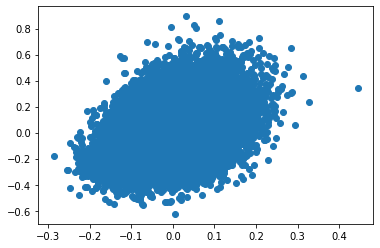

In [45]:
plt.scatter(df_predint["cal_pred"], df_predint["pheno"])

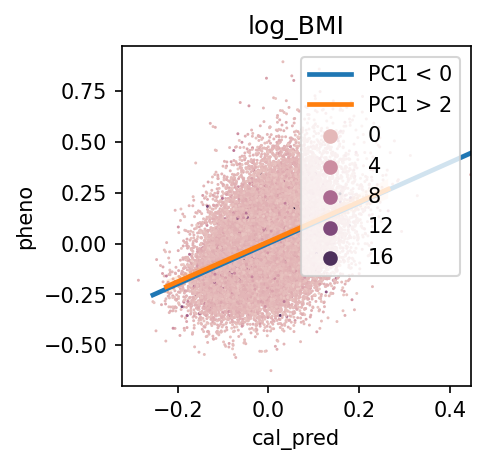

In [46]:
# visualize
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(data=df_predint, x="cal_pred", y="pheno", linewidth=0, s=2, hue="PC1")
sns.regplot(
    data=df_predint[df_predint.PC1 < 0],
    x="cal_pred",
    y="pheno",
    scatter=False,
    label="PC1 < 0",
)
sns.regplot(
    data=df_predint[df_predint.PC1 > 2],
    x="cal_pred",
    y="pheno",
    scatter=False,
    label="PC1 > 2",
)
ax.legend()
ax.set_title(trait)
fig.show()

In [8]:
def load_data(trait, group):
    df_trait = pd.read_csv(
        os.path.join(DATA_DIR, f"{trait}.tsv.gz"), index_col=0, sep="\t"
    )

    if indiv_group == "white":
        df_trait = df_trait[df_trait.group == "United Kingdom"]
    elif indiv_group == "other":
        df_trait = df_trait[~(df_trait.group == "United Kingdom")]
    else:
        raise NotImplementedError

    df_trait = df_trait.rename(columns={"MEAN": "PGS", "PHENO": "pheno"}).dropna(
        subset=["pheno", "PGS"]
    )

    # impute with column average and standardize covariates
    for col in ["PGS"] + COVAR_COLS:
        df_trait[col] = df_trait[col].fillna(df_trait[col].mean())
        df_trait[col] = (df_trait[col] - df_trait[col].mean()) / df_trait[col].std()

    df_trait = df_trait[["pheno", "PGS"] + COVAR_COLS]

    # load fitted results
    return df_trait

In [9]:
df_trait = load_data(trait=trait, group=indiv_group)

In [10]:
prefix = f"out/model-fit/joint+slope/{trait}-{indiv_group}"
df_trait = pd.read_csv(
    f"{prefix}.predint.tsv",
    sep="\t",
    index_col=0,
)
df_params = pd.read_csv(f"{prefix}.params.tsv", sep="\t", index_col=0)

In [11]:
def display_stats(df, group):
    from scipy.stats import linregress

    if len(np.unique(df[group])) > 5:
        q_var = pd.qcut(df[group], 5)
    else:
        q_var = df[group]

    print("## slope of pheno ~ pred:")
    display(
        df.assign(q=q_var)
        .groupby("q")
        .apply(lambda tmp: linregress(x=tmp["cal_pred"], y=tmp["pheno"]).slope)
    )
    print("## residual variance of pheno ~ pred:")
    display(
        df.assign(q=q_var)
        .groupby("q")
        .apply(lambda tmp: np.mean((tmp["pheno"] - tmp["cal_pred"]) ** 2))
    )
    print("## total variance of pheno")
    display(df.assign(q=q_var).groupby("q").apply(lambda tmp: np.var(tmp["pheno"])))

    print("## total variance of pred")
    display(df.assign(q=q_var).groupby("q").apply(lambda tmp: np.var(tmp["cal_pred"])))

    print("## Pearson's R2 of pheno ~ pred:")
    display(
        df.assign(q=q_var)
        .groupby("q")
        .apply(lambda tmp: stats.pearsonr(tmp["pheno"], tmp["cal_pred"])[0] ** 2)
    )

## slope of pheno ~ pred:


q
(-2.508, -0.638]    1.085773
(-0.638, -0.258]    1.068691
(-0.258, 0.0775]    1.087756
(0.0775, 0.491]     1.021968
(0.491, 18.934]     1.039708
dtype: float64

## residual variance of pheno ~ pred:


q
(-2.508, -0.638]    0.638022
(-0.638, -0.258]    0.632123
(-0.258, 0.0775]    0.660927
(0.0775, 0.491]     0.657914
(0.491, 18.934]     0.635825
dtype: float64

## total variance of pheno


q
(-2.508, -0.638]    0.747880
(-0.638, -0.258]    0.741371
(-0.258, 0.0775]    0.775375
(0.0775, 0.491]     0.759756
(0.491, 18.934]     0.743680
dtype: float64

## total variance of pred


q
(-2.508, -0.638]    0.096700
(-0.638, -0.258]    0.098573
(-0.258, 0.0775]    0.099247
(0.0775, 0.491]     0.099006
(0.491, 18.934]     0.103097
dtype: float64

## Pearson's R2 of pheno ~ pred:


q
(-2.508, -0.638]    0.152431
(-0.638, -0.258]    0.151854
(-0.258, 0.0775]    0.151449
(0.0775, 0.491]     0.136101
(0.491, 18.934]     0.149858
dtype: float64

In [46]:
from admix.data import quantile_normalize

(array([  10.,  156.,  968., 3092., 4771., 4405., 3525., 2446., 1033.,
         131.]),
 array([-1.07377 , -0.595147, -0.116524,  0.362099,  0.840722,  1.319345,
         1.797968,  2.276591,  2.755214,  3.233837,  3.71246 ]),
 <BarContainer object of 10 artists>)

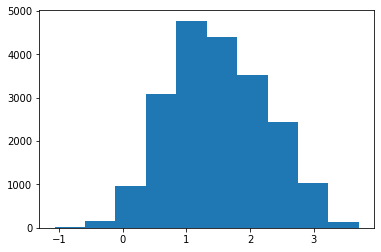

In [21]:
plt.hist(df_tmp["cal_slope"])

In [24]:
df_tmp

,pheno,PGS,AGE,SEX,DEPRIVATION_INDEX,log_BMI,income,ever_smoked,drink_alcohol,glasses,...,PC4,PC5,PC6,PC7,PC8,PC9,PC10,cal_slope,cal_pred,cal_predstd
indiv,,,,,,,,,,,,,,,,,,,,,
4086323,-0.366559,0.970875,-1.994930,-0.926803,-0.735929,-0.958776,1.204470e+00,-1.243770,0.182045,-2.899860,...,-0.236751,0.208017,0.743892,0.861546,0.527107,-3.507930,-0.181754,3.290110,-0.163226,0.630625
4435628,0.351441,0.524977,0.147133,-0.926803,2.148100,-0.620406,-4.458920e-01,0.806624,0.182045,0.345169,...,0.461170,-0.060820,-0.995071,-0.132937,0.157710,0.919688,-1.429430,1.403910,0.272007,0.799250
5353660,0.274441,1.101800,-0.860898,-0.926803,-1.575110,-0.865650,4.495690e-01,-1.243770,0.182045,-2.899860,...,-0.143927,-0.766476,-1.305330,0.009785,0.443624,-0.942518,0.362390,2.483170,0.410565,0.709984
2144492,-1.002560,0.405528,-0.356882,-0.926803,2.658490,0.242282,1.204470e+00,0.806624,0.182045,0.345169,...,0.399797,-0.253312,-1.128590,-0.357973,0.548986,-0.661099,1.298530,1.539290,0.236120,0.782087
2858807,-0.759559,-1.588490,1.407170,-0.926803,1.399230,-2.074290,-1.612860e+00,0.806624,0.182045,0.345169,...,-0.179985,-0.970183,0.829981,0.760151,-0.002068,-0.197183,0.966355,0.823620,-0.108753,0.763309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118302,0.981441,0.711184,-0.482886,-0.926803,0.632037,-0.088691,4.495690e-01,-1.243770,0.182045,0.345169,...,0.185293,0.151372,1.062980,1.483620,1.478880,0.253280,-0.558070,1.890620,0.337402,0.743578
2616445,0.367441,0.675637,1.281170,-0.926803,-1.141960,1.869680,-4.458920e-01,0.806624,-5.699170,0.345169,...,-0.331159,0.571842,-0.623978,-0.002966,0.235029,-0.000235,0.788013,0.001223,0.000753,1.014730
3269435,0.660441,1.042620,-0.986902,-0.926803,0.311763,1.748730,6.255740e-16,-1.243770,0.182045,0.345169,...,-0.958555,-1.360960,-1.225830,0.072815,-0.406635,0.160018,-0.257787,1.652610,0.578499,0.816774


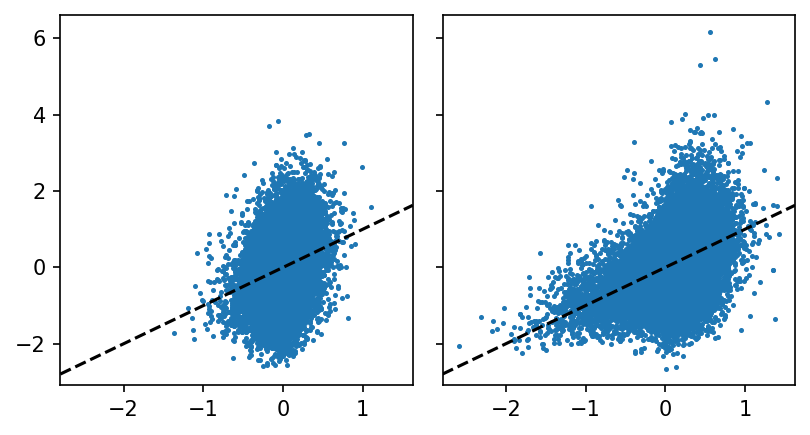

In [30]:
fig, axes = plt.subplots(figsize=(5.5, 3), dpi=150, ncols=2, sharex=True, sharey=True)

for i in range(2):
    ax = axes[i]
    if i == 0:
        df_tmp = df_trait[df_trait.SEX > 0]
    elif i == 1:
        df_tmp = df_trait[df_trait.SEX < 0]

    ax.scatter(df_tmp["cal_pred"], df_tmp["pheno"], s=2)
    #     print(
    #         sm.WLS(
    #             endog=df_tmp["pheno"],
    #             exog=df_tmp["cal_pred"],
    #             weights=1 / df_tmp["cal_predstd"],
    #         )
    #         .fit()
    #         .summary()
    #     )
    ax.axline((0, 0), slope=1, color="black", ls="--")
plt.tight_layout()
plt.show()

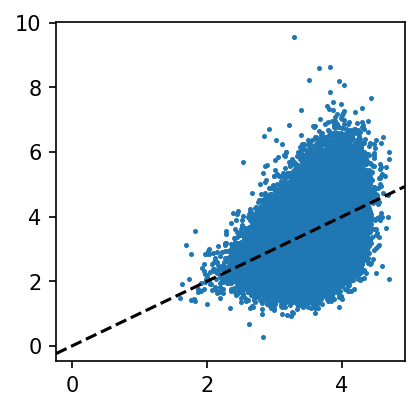

In [65]:

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.axline((0, 0), slope=1, color="black", ls="--")
plt.show()

In [58]:
sm.OLS(endog=df_tmp["pheno"], exog=sm.add_constant(df_tmp["cal_pred"])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pheno   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     712.4
Date:                Mon, 04 Jul 2022   Prob (F-statistic):          8.67e-150
Time:                        13:43:42   Log-Likelihood:                -8671.6
No. Observations:                7259   AIC:                         1.735e+04
Df Residuals:                    7257   BIC:                         1.736e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7316      0.094      7.743      0.000       0.546       0.917
cal_pred       0.7717      0.029     26.690      0.000       0.715       0.828
==============================================================================
Omnibus:                      185.856   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.026
Skew:                           0.367   Prob(JB):                     6.73e-46
Kurtosis:                       3.387   Cond. No.                         36.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
sm.OLS(
    endog=df_trait["pheno"],
    exog=sm.add_constant(
        np.c_[
            df_trait["cal_pred"],
            quantile_normalize(df_trait["cal_pred"] * df_trait["PC1"]),
        ]
    ),
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pheno   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     7247.
Date:                Mon, 04 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:42:04   Log-Likelihood:                -86089.
No. Observations:               72473   AIC:                         1.722e+05
Df Residuals:                   72470   BIC:                         1.722e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1065      0.034      3.176      0.001       0.041       0.172
x1             0.9694      0.010    101.311      0.000       0.951       0.988
x2            -0.0199      0.003     -5.859      0.000      -0.027      -0.013
==============================================================================
Omnibus:                     1107.662   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1268.193
Skew:                           0.258   Prob(JB):                    4.13e-276
Kurtosis:                       3.391   Cond. No.                         43.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
df_trait

,pheno,PGS,AGE,SEX,DEPRIVATION_INDEX,log_BMI,income,ever_smoked,drink_alcohol,glasses,...,PC4,PC5,PC6,PC7,PC8,PC9,PC10,cal_slope,cal_pred,cal_predstd
indiv,,,,,,,,,,,,,,,,,,,,,
4633435,2.687,-0.090883,-0.450414,-0.876314,-0.707176,-1.871980,-3.281220e-01,0.900238,0.379825,0.434115,...,0.189807,-0.873726,0.075648,0.265083,-0.270969,0.845105,0.273706,1.331650,3.26851,0.662908
4922412,2.956,1.084240,-1.615370,-0.876314,-0.546017,-0.280435,1.976370e+00,-1.125510,0.379825,-2.326940,...,0.718318,-0.356307,-0.265199,-0.073702,-0.597678,0.377435,-1.051430,1.395940,3.61511,0.711964
3552392,4.650,1.032800,0.365052,-0.876314,0.406196,0.773054,-3.281220e-01,-1.125510,0.379825,0.434115,...,0.442277,-0.085269,-0.033664,0.047928,-0.216188,-3.180160,0.252219,1.014650,4.02531,0.847864
3627963,1.286,-1.097530,-1.615370,-0.876314,-0.554152,-2.111800,-6.226120e-16,-1.125510,0.379825,0.434115,...,-0.516144,0.412448,-0.845656,-0.067610,0.397038,-0.069311,0.710261,1.449420,2.32096,0.528930
3356297,4.005,1.219930,0.714537,-0.876314,-0.542016,-0.482338,-1.489560e+00,0.900238,0.379825,0.434115,...,0.361023,-0.685844,-0.244357,-0.028639,-0.383196,0.114657,0.022837,1.045820,4.08587,0.890057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130254,3.110,1.097890,-1.265880,-0.876314,-0.912837,0.226398,1.314430e+00,0.900238,0.379825,0.434115,...,-0.168278,-0.554224,-0.479487,0.336832,0.073101,0.210521,0.444504,1.311070,3.78250,0.738045
5375742,4.280,-0.443035,-1.149390,1.141130,-1.247430,0.327409,-6.226120e-16,-1.125510,-2.776090,0.434115,...,-0.062357,-0.549807,-0.617947,-0.022606,0.305873,0.030974,-0.200587,1.007360,3.39634,0.702463
5188752,3.235,0.634816,1.530000,-0.876314,-0.795082,1.170510,-1.489560e+00,-1.125510,-2.776090,0.434115,...,-3.295600,2.306130,-0.868905,-2.405480,-1.591190,-0.096593,0.137078,0.735504,3.56450,1.024820


In [ ]:
# df_trait = pd.read_csv(os.path.join(DATA_DIR, f"{trait}.tsv.gz"), index_col=0, sep="\t")

# if indiv_group == "white":
#     df_trait = df_trait[df_trait.group == "United Kingdom"]
# elif indiv_group == "other":
#     df_trait = df_trait[~(df_trait.group == "United Kingdom")]
# else:
#     raise NotImplementedError

# df_trait = df_trait.rename(columns={"MEAN": "PGS", "PHENO": "pheno"}).dropna(
#     subset=["pheno", "PGS"]
# )

# # impute with column average and standardize covariates
# for col in ["PGS"] + COVAR_COLS:
#     df_trait[col] = df_trait[col].fillna(df_trait[col].mean())
#     df_trait[col] = (df_trait[col] - df_trait[col].mean()) / df_trait[col].std()

# df_trait = df_trait[["pheno", "PGS"] + COVAR_COLS]
# fit_cols = [col for col in FIT_COLS if col != trait]

In [ ]:
# def estimate(df, mean_cols, var_cols, slope_cols=None):
#     df = df.copy()
#     # format data set
#     mean_covar = df[mean_cols]
#     var_covar = df[var_cols]
#     y = df["pheno"].values

#     if slope_cols is None:
#         slope_covar = None
#     else:
#         slope_covar = df[slope_cols]
#     if slope_cols is not None:
#         print("Slope columns: " + " ".join(slope_cols))
#     fit = calpgs.fit_het_linear2(
#         y=y,
#         mean_covar=mean_covar,
#         var_covar=var_covar,
#         slope_covar=slope_covar,
#         return_est_covar=True,
#         trace=True,
#     )
#     if slope_cols is None:
#         beta, gamma, beta_cov, gamma_cov = fit
#     else:
#         (
#             beta,
#             gamma,
#             intercept_coef,
#             slope_coef,
#             beta_cov,
#             gamma_cov,
#             intercept_vcov,
#             slope_vcov,
#         ) = fit

#     if slope_cols is None:
#         pred_mean = sm.add_constant(mean_covar).dot(beta)
#         pred_std = np.sqrt(np.exp(sm.add_constant(var_covar).dot(gamma)))
#     else:
#         pred_slope = 1 + slope_covar.dot(slope_coef)
#         pred_mean = mean_covar.dot(beta) * pred_slope + intercept_coef
#         pred_std = np.sqrt(np.exp(sm.add_constant(var_covar).dot(gamma)))
#     df["cal_pred"], df["cal_predstd"], df["cal_slope"] = pred_mean, pred_std, pred_slope
#     return df